In [335]:
'''
Imports
'''
import h5py
# import os
# import shutil
import csv
import pandas as pd
import numpy as np
from io import BytesIO
from PIL import Image
import cv2
import torch, torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import v2
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedShuffleSplit
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [336]:
'''
Constants
'''
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
CLASSES = 1
EPOCH = 10
NEG_POS_RATIO = 25

In [337]:
# Paths
## Kaggle
# TRAIN_HDF5_PATH = "/kaggle/input/isic-2024-challenge/train-image.hdf5"
# TEST_HDF5_PATH = "/kaggle/input/isic-2024-challenge/test-image.hdf5"
# ANNOTATIONS_FILE = "/kaggle/input/isic-2024-challenge/train-metadata.csv"
# MODEL_SAVE_PATH = "/kaggle/working/model_resnet34_aug_2-2.pth"
# LOG_FILE = "/kaggle/working/log_res34_aug.csv"
# RESNET34_IMAGENET_WEIGHTS_PYTORCH = "/kaggle/input/resnet34-weights/pytorch/nan/1/resnet34-b627a593.pth"        # change properly
# SUBMISSION_FILE_PATH = "/kaggle/working/submission.csv"

## Local_Srijan
TRAIN_HDF5_PATH = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Data\\train-image.hdf5"
TEST_HDF5_PATH = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Data\\test-image.hdf5"
ANNOTATIONS_FILE = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Data\\train-metadata.csv"
MODEL_SAVE_PATH = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\model_resnet34_aug_2-2.pth"
LOG_FILE = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Codebase\\Classification_v2\\log_res34_aug.csv"
RESNET34_IMAGENET_WEIGHTS_PYTORCH = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\resnet34-b627a593.pth"        # change properly
SUBMISSION_FILE_PATH = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Codebase\\Classification_v2\\submission.csv"

## Local_Sruba
# TRAIN_HDF5_PATH = "E:\\isic-2024-challenge\\Dataset\\train-image.hdf5"
# TEST_HDF5_PATH = "E:\\isic-2024-challenge\\Dataset\\test-image.hdf5"
# ANNOTATIONS_FILE = "E:\\isic-2024-challenge\\Dataset\\train-metadata.csv"
# MODEL_SAVE_PATH = "E:\\isic-2024-challenge\\model_resnet34_aug_2-2.pth"
# LOG_FILE = "E:\\isic-2024-challenge\\Codebase\\Classification_v2\\log_res34_aug.csv"
# RESNET34_IMAGENET_WEIGHTS_PYTORCH = "E:\\isic-2024-challenge\\resnet34-b627a593.pth"        # change properly
# SUBMISSION_FILE_PATH = "E:\\isic-2024-challenge\\Codebase\\Classification_v2\\submission.csv"

In [338]:
annotations_df_full = pd.read_csv(ANNOTATIONS_FILE, low_memory=False)
df_positive_all = annotations_df_full[annotations_df_full["target"] == 1].reset_index(drop=True)
df_negative_all = annotations_df_full[annotations_df_full["target"] == 0].reset_index(drop=True)

In [339]:
print(df_positive_all.shape, df_negative_all.shape)

(393, 55) (400666, 55)


In [340]:
df_negative_trunc = df_negative_all.sample(df_positive_all.shape[0]*NEG_POS_RATIO)
df_negative_trunc.shape

(9825, 55)

In [341]:
annotations_df_trunc = pd.concat([df_positive_all, df_negative_trunc]).sample(frac=1).reset_index()
annotations_df_trunc.shape

(10218, 56)

In [342]:
'''
DataClass
'''
class ISIC2024_HDF5(Dataset):
    def __init__(self, hdf5_path, annotations_df=None, transform=None):
        self.hdf5_path = hdf5_path
        self.annotations_df = annotations_df
        self.transform = transform
        self.image_ids = []
        
        self.hdf5_file = h5py.File(self.hdf5_path, 'r')

        if self.annotations_df is not None:
            self.image_ids = annotations_df['isic_id']
            self.labels = annotations_df.set_index('isic_id')['target'].to_dict()
        else:
            self.image_ids = list(self.hdf5_file.keys())
            

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = Image.open(BytesIO(self.hdf5_file[image_id][()]))
        # image = self.load_image(self.hdf5_file[image_id][()])

        if self.transform:
            image = self.transform(image)

        # Check for NaN in image
        if torch.isnan(image).any():
            print(f"NaN detected in image {image_id}")

        if self.annotations_df is not None:
            label = self.labels[image_id]
            # Check for NaN in label
            if np.isnan(label):
                print(f"NaN detected in label for image {image_id}")
            return image, label, image_id
        else:
            return image, image_id
        
    # def load_image(self, image_data):
    #     # Decode the image data from HDF5 file using OpenCV
    #     image = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    #     # image = np.transpose(image, (1, 2, 0))  # Convert HxWxC to CxHxW
    #     return image
    
    def close(self):
        self.hdf5_file.close()

In [343]:
'''
Transformations
'''
TRAIN_TRANS = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.RandomRotation(degrees=(0, 360)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale = True)
])
TEST_TRANS = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True)
])

In [344]:
train_dataset = ISIC2024_HDF5(TRAIN_HDF5_PATH, annotations_df_trunc, transform=TRAIN_TRANS)
len(train_dataset)

10218

In [345]:
test_dataset = ISIC2024_HDF5(TEST_HDF5_PATH, transform=TEST_TRANS)
len(test_dataset)

3

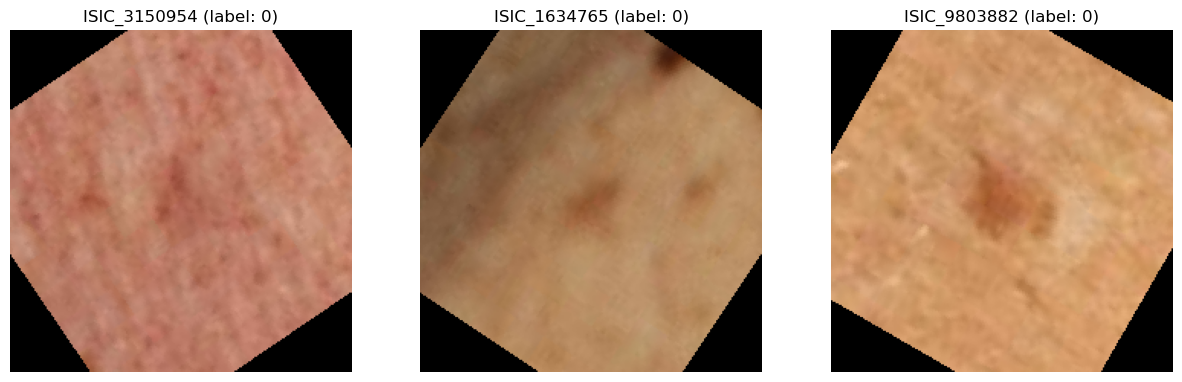

In [346]:
def visualize_train_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC and convert to numpy
        plt.imshow(image)
        if titles:
            plt.title(f"{titles[0][i]} (label: {titles[1][i]})")
        plt.axis('off')
    plt.show()
indices = np.random.choice(len(train_dataset), size=3, replace=False)
images, label, image_ids  = zip(*[train_dataset[i] for i in indices])
visualize_train_images(images, titles=[image_ids, label])

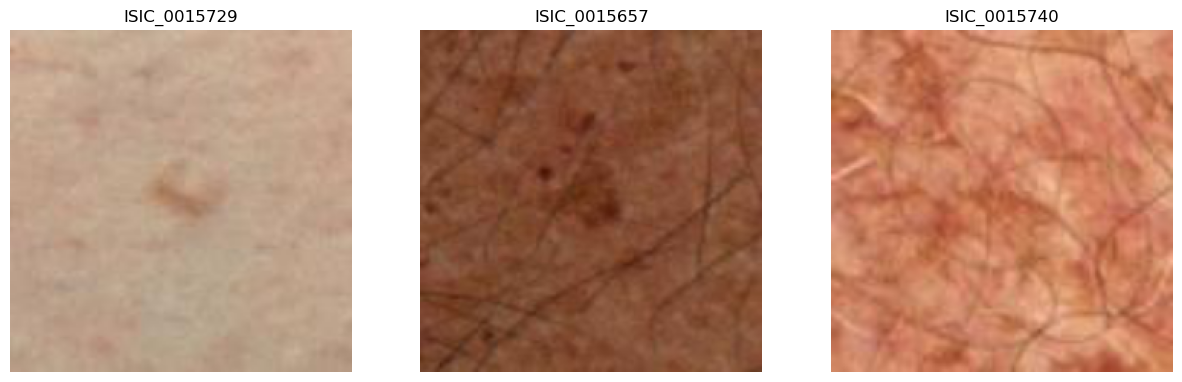

In [347]:
def visualize_test_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC and convert to numpy
        plt.imshow(image)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()
indices = np.random.choice(len(test_dataset), size=3, replace=False)
images, image_ids  = zip(*[test_dataset[i] for i in indices])
visualize_test_images(images, titles=image_ids)

In [348]:
data_transforms = {
    "train": A.Compose([
        A.Resize(224, 224),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "test": A.Compose([
        A.Resize(224, 224),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}
class ISIC2024_HDF5_ALBUM(Dataset):
    def __init__(self, hdf5_path, annotations_df=None, transform=None):
        self.hdf5_path = hdf5_path
        self.annotations_df = annotations_df
        self.transform = transform
        self.image_ids = []
        
        self.hdf5_file = h5py.File(self.hdf5_path, 'r')

        if self.annotations_df is not None:
            self.image_ids = annotations_df['isic_id']
            self.labels = annotations_df.set_index('isic_id')['target'].to_dict()
        else:
            self.image_ids = list(self.hdf5_file.keys())
            

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = np.array(Image.open(BytesIO(self.hdf5_file[image_id][()])))
        
        # image = self.load_image(self.hdf5_file[image_id][()])

        if self.transform:
            # image = self.transform(image)
            image = self.transform(image=image)["image"]        # Albumentations returns a dictionary with keys like 'image', 'mask', etc., depending on the transformations applied.

        # Check for NaN in image
        if torch.isnan(image).any():
            print(f"NaN detected in image {image_id}")

        if self.annotations_df is not None:
            label = self.labels[image_id]
            # Check for NaN in label
            if np.isnan(label):
                print(f"NaN detected in label for image {image_id}")
            return image, label, image_id
        else:
            return image, image_id
        
    # def load_image(self, image_data):
    #     # Decode the image data from HDF5 file using OpenCV
    #     image = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    #     # image = np.transpose(image, (1, 2, 0))  # Convert HxWxC to CxHxW
    #     return image
    
    def close(self):
        self.hdf5_file.close()
train_dataset_album = ISIC2024_HDF5_ALBUM(TRAIN_HDF5_PATH, annotations_df_trunc, transform=data_transforms["train"])
test_dataset_album = ISIC2024_HDF5_ALBUM(TEST_HDF5_PATH, transform=data_transforms["test"])
print(len(train_dataset_album), len(test_dataset_album))

10218 3


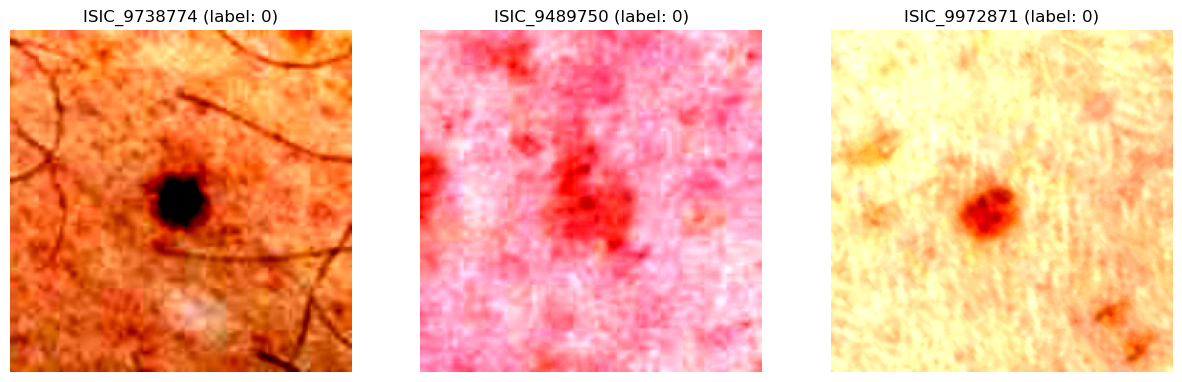

In [349]:
def visualize_train_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC and convert to numpy
        plt.imshow(image)
        if titles:
            plt.title(f"{titles[0][i]} (label: {titles[1][i]})")
        plt.axis('off')
    plt.show()
indices = np.random.choice(len(train_dataset_album), size=3, replace=False)
images, label, image_ids  = zip(*[train_dataset_album[i] for i in indices])
visualize_train_images(images, titles=[image_ids, label])

In [350]:
'''
DataLoader
'''
def get_loader(dataset_cls=ISIC2024_HDF5_ALBUM,
               train_hdf5_path=TRAIN_HDF5_PATH, 
               test_hdf5_path=TEST_HDF5_PATH, 
               train_labels_df=annotations_df_trunc, 
               train_img_trans=data_transforms["train"], 
               test_img_trans=data_transforms["test"], 
               batch=32, 
               seed=None):
    
    train_dataset_all = dataset_cls(hdf5_path=train_hdf5_path, annotations_df=train_labels_df, transform=train_img_trans)
    test_dataset = dataset_cls(hdf5_path=test_hdf5_path, transform=test_img_trans)

    train_annotations_all = train_labels_df
    labels = train_annotations_all['target']
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    train_idx, val_idx = next(splitter.split(train_annotations_all, labels))
    train_subset = Subset(train_dataset_all, train_idx)
    val_subset = Subset(train_dataset_all, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch, shuffle=True)
    test_loader = DataLoader(test_dataset, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [351]:
train_dl, valid_dl, test_dl = get_loader(seed=42)

In [352]:
model_resnet = torchvision.models.resnet34(weights=None)
model_resnet.load_state_dict(torch.load(RESNET34_IMAGENET_WEIGHTS_PYTORCH))
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features=num_ftrs, out_features=1)
model_resnet.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [353]:
'''
Utils
'''
def pauc_above_tpr(y_true, y_pred, min_tpr=0.80):
    y_true = abs(np.array(y_true) - 1)
    y_pred = -1.0 * np.array(y_pred)
    
    # Check for NaN values
    if np.isnan(y_true).any() or np.isnan(y_pred).any():
        print("NaN values detected in inputs to pauc_above_tpr")
        return 0
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    max_fpr = 1 - min_tpr

    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    
    if len(fpr) < 2:
        print("Warning: Not enough points to compute pAUC. Returning 0.")
        return 0
    
    partial_auc = auc(fpr, tpr)

    return partial_auc

def evaluate(loader, model, criterion):
    metric = BinaryF1Score(threshold=0.5).to(DEVICE)
    prec = BinaryPrecision(threshold=0.5).to(DEVICE)
    recall = BinaryRecall(threshold=0.5).to(DEVICE)
    acc = BinaryAccuracy(threshold=0.5).to(DEVICE)
    loss = 0.0
    num_corr = 0
    num_samp = 0
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels, _ in tqdm(loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs).squeeze(1)
            
            # Check for NaN in outputs
            if torch.isnan(outputs).any():
                print("NaN detected in model outputs")
                continue
            
            loss += criterion(outputs, labels.float()).item()
            preds = torch.sigmoid(outputs)
            num_corr += ((preds > 0.5) == labels).sum()
            num_samp += preds.size(0)
            metric.update(preds, labels)
            prec.update(preds, labels)
            recall.update(preds, labels)
            acc.update(preds, labels)
            all_preds.extend(preds.cpu().detach().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = loss / len(loader)
    accu = float(num_corr) / float(num_samp)
    pauc = pauc_above_tpr(all_labels, all_preds)
    
    print(f"Total loss: {loss}, Average loss: {avg_loss}")
    print(f"Got {num_corr}/{num_samp} correct with accuracy {accu*100:.2f}")
    print(f"pAUC above 80% TPR: {pauc:.3f}, Accuracy: {acc.compute().item():.3f}, precision: {prec.compute().item():.3f}, recall: {recall.compute().item():.3f}, F1Score: {metric.compute().item():.3f}")
    model.train()

    return avg_loss, acc.compute().item(), prec.compute().item(), recall.compute().item(), metric.compute().item(), pauc

def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def load_model():
    model = torchvision.models.resnet34(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(in_features=num_ftrs, out_features=1)
    model.load_state_dict(torch.load(MODEL_SAVE_PATH)["state_dict"])
    model.to(DEVICE)
    model.eval()
    return model

def create_submission(model, test_loader):
    predictions = []
    image_ids = []

    with torch.no_grad():
        for inputs, image_names in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).squeeze(1)
            probs = torch.sigmoid(outputs)
            predictions.extend(probs.cpu().numpy())
            image_ids.extend(image_names)  # Append all image names from the batch

    # Check if the lengths match
    if len(image_ids) != len(predictions):
        print(f"Warning: Number of image IDs ({len(image_ids)}) does not match number of predictions ({len(predictions)})")

    # Create DataFrame
    submission_df = pd.DataFrame({
        'isic_id': image_ids,
        'target': predictions
    })

    # Save to CSV
    submission_df.to_csv(SUBMISSION_FILE_PATH, index=False)
    print(f"Submission file saved to {SUBMISSION_FILE_PATH}")

In [354]:
'''
Training Loop
'''
def train(epochs, model, train_dl, val_dl):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)  # Initialize CosineAnnealingLR scheduler
    criterion = nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    best_val_pauc = -1.0  # Initialize with a very low value
    
    with open(LOG_FILE, 'w', newline='') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(['Epoch', 'Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1 Score', 'Validation pAUC'])
        
        for epoch in range(epochs):
            print(f"\n | Epoch: {epoch+1}")
            total_loss = 0
            num_corr = 0
            num_samp = 0
            loop = tqdm(train_dl)
            model.train()
            
            for batch_idx, (inputs, labels, _) in enumerate(loop):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                
                with torch.cuda.amp.autocast():
                    outputs = model(inputs).squeeze(1)
                    loss = criterion(outputs, labels.float())
                
                if torch.isnan(loss):
                    print(f"NaN loss detected at batch {batch_idx}")
                    continue
                
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                
                preds = torch.sigmoid(outputs)
                num_corr += ((preds > 0.5) == labels).sum()
                num_samp += preds.size(0)
                total_loss += loss.item()
                loop.set_postfix(loss=loss.item())
            
            avg_loss = total_loss / len(train_dl)
            acc = num_corr / num_samp
            print(f"| Epoch {epoch+1}/{epochs} total training loss: {total_loss}, average training loss: {avg_loss}.")
            print("On Validation Data:")
            
            model.eval()
            with torch.inference_mode():
                val_loss, val_acc, val_pre, val_rec, val_f1, val_pauc = evaluate(val_dl, model, criterion)
            
            row = [epoch+1, avg_loss, acc.item(), val_loss, val_acc, val_pre, val_rec, val_f1, val_pauc]
            csv_writer.writerow(row)
            
            if val_pauc > best_val_pauc:
                best_val_pauc = val_pauc
                print(f'Validation pAUC improved ({best_val_pauc} > {best_val_pauc}), saving model...')
                checkpoint = {
                    "state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                }
                save_checkpoint(checkpoint, MODEL_SAVE_PATH)
                print(f'Model saved at {MODEL_SAVE_PATH}')
            
            print(f'Current Best Validation pAUC: {best_val_pauc}')
            
            scheduler.step()  # Update learning rate for next epoch
        
    print('Training complete.')

In [355]:
'''
Training
'''
train(epochs=EPOCH, model=model_resnet, train_dl=train_dl, val_dl=valid_dl)


 | Epoch: 1


100%|██████████| 256/256 [02:09<00:00,  1.97it/s, loss=0.021] 


| Epoch 1/10 total training loss: 45.754533030092716, average training loss: 0.17872864464879967.
On Validation Data:


100%|██████████| 64/64 [00:23<00:00,  2.69it/s]


Total loss: 7.432876728475094, Average loss: 0.11613869888242334
Got 1966/2044 correct with accuracy 96.18
pAUC above 80% TPR: 0.124, Accuracy: 0.962, precision: 0.533, recall: 0.101, F1Score: 0.170
Validation pAUC improved (0.12417818146680834 > 0.12417818146680834), saving model...
=> Saving checkpoint
Model saved at D:\ISIC 2024 - Skin Cancer Detection with 3D-TBP\model_resnet34_aug_2-2.pth
Current Best Validation pAUC: 0.12417818146680834

 | Epoch: 2


100%|██████████| 256/256 [01:18<00:00,  3.26it/s, loss=0.00832]


| Epoch 2/10 total training loss: 32.75071887485683, average training loss: 0.1279324956049095.
On Validation Data:


100%|██████████| 64/64 [00:18<00:00,  3.54it/s]


Total loss: 7.6936366143636405, Average loss: 0.12021307209943188
Got 1976/2044 correct with accuracy 96.67
pAUC above 80% TPR: 0.119, Accuracy: 0.967, precision: 0.704, recall: 0.241, F1Score: 0.358
Current Best Validation pAUC: 0.12417818146680834

 | Epoch: 3


100%|██████████| 256/256 [00:58<00:00,  4.34it/s, loss=0.0546] 


| Epoch 3/10 total training loss: 30.394661023281515, average training loss: 0.11872914462219342.
On Validation Data:


100%|██████████| 64/64 [00:14<00:00,  4.53it/s]


Total loss: 8.07709685806185, Average loss: 0.1262046384072164
Got 1962/2044 correct with accuracy 95.99
pAUC above 80% TPR: 0.128, Accuracy: 0.960, precision: 0.477, recall: 0.392, F1Score: 0.431
Validation pAUC improved (0.12819145167004858 > 0.12819145167004858), saving model...
=> Saving checkpoint
Model saved at D:\ISIC 2024 - Skin Cancer Detection with 3D-TBP\model_resnet34_aug_2-2.pth
Current Best Validation pAUC: 0.12819145167004858

 | Epoch: 4


100%|██████████| 256/256 [01:33<00:00,  2.75it/s, loss=0.00731]


| Epoch 4/10 total training loss: 28.89816606650129, average training loss: 0.11288346119727066.
On Validation Data:


100%|██████████| 64/64 [00:12<00:00,  5.16it/s]


Total loss: 6.684643457178026, Average loss: 0.10444755401840666
Got 1981/2044 correct with accuracy 96.92
pAUC above 80% TPR: 0.134, Accuracy: 0.969, precision: 0.735, recall: 0.316, F1Score: 0.442
Validation pAUC improved (0.13420169420555927 > 0.13420169420555927), saving model...
=> Saving checkpoint
Model saved at D:\ISIC 2024 - Skin Cancer Detection with 3D-TBP\model_resnet34_aug_2-2.pth
Current Best Validation pAUC: 0.13420169420555927

 | Epoch: 5


100%|██████████| 256/256 [01:11<00:00,  3.58it/s, loss=0.00608]


| Epoch 5/10 total training loss: 28.22810916765593, average training loss: 0.11026605143615598.
On Validation Data:


100%|██████████| 64/64 [00:16<00:00,  3.77it/s]


Total loss: 8.334520608652383, Average loss: 0.13022688451019349
Got 1974/2044 correct with accuracy 96.58
pAUC above 80% TPR: 0.135, Accuracy: 0.966, precision: 0.645, recall: 0.253, F1Score: 0.364
Validation pAUC improved (0.13455084227139494 > 0.13455084227139494), saving model...
=> Saving checkpoint
Model saved at D:\ISIC 2024 - Skin Cancer Detection with 3D-TBP\model_resnet34_aug_2-2.pth
Current Best Validation pAUC: 0.13455084227139494

 | Epoch: 6


100%|██████████| 256/256 [02:23<00:00,  1.79it/s, loss=0.338]  


| Epoch 6/10 total training loss: 29.44033572007902, average training loss: 0.11500131140655867.
On Validation Data:


100%|██████████| 64/64 [00:28<00:00,  2.25it/s]


Total loss: 7.587771527003497, Average loss: 0.11855893010942964
Got 1981/2044 correct with accuracy 96.92
pAUC above 80% TPR: 0.134, Accuracy: 0.969, precision: 0.648, recall: 0.443, F1Score: 0.526
Current Best Validation pAUC: 0.13455084227139494

 | Epoch: 7


100%|██████████| 256/256 [01:28<00:00,  2.90it/s, loss=0.44]   


| Epoch 7/10 total training loss: 27.402150205569342, average training loss: 0.10703964924050524.
On Validation Data:


100%|██████████| 64/64 [00:28<00:00,  2.25it/s]


Total loss: 8.240183652378619, Average loss: 0.12875286956841592
Got 1973/2044 correct with accuracy 96.53
pAUC above 80% TPR: 0.146, Accuracy: 0.965, precision: 0.600, recall: 0.304, F1Score: 0.403
Validation pAUC improved (0.1460611331207524 > 0.1460611331207524), saving model...
=> Saving checkpoint
Model saved at D:\ISIC 2024 - Skin Cancer Detection with 3D-TBP\model_resnet34_aug_2-2.pth
Current Best Validation pAUC: 0.1460611331207524

 | Epoch: 8


100%|██████████| 256/256 [01:13<00:00,  3.51it/s, loss=0.0105] 


| Epoch 8/10 total training loss: 25.60434116097167, average training loss: 0.10001695766004559.
On Validation Data:


100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


Total loss: 7.686219163006172, Average loss: 0.12009717442197143
Got 1974/2044 correct with accuracy 96.58
pAUC above 80% TPR: 0.134, Accuracy: 0.966, precision: 0.585, recall: 0.392, F1Score: 0.470
Current Best Validation pAUC: 0.1460611331207524

 | Epoch: 9


100%|██████████| 256/256 [00:57<00:00,  4.44it/s, loss=0.0168] 


| Epoch 9/10 total training loss: 23.942995445569977, average training loss: 0.09352732595925772.
On Validation Data:


100%|██████████| 64/64 [00:13<00:00,  4.58it/s]


Total loss: 7.1890907504130155, Average loss: 0.11232954297520337
Got 1983/2044 correct with accuracy 97.02
pAUC above 80% TPR: 0.134, Accuracy: 0.970, precision: 0.667, recall: 0.456, F1Score: 0.541
Current Best Validation pAUC: 0.1460611331207524

 | Epoch: 10


100%|██████████| 256/256 [01:24<00:00,  3.04it/s, loss=0.00359]


| Epoch 10/10 total training loss: 24.578413380193524, average training loss: 0.09600942726638095.
On Validation Data:


100%|██████████| 64/64 [00:19<00:00,  3.22it/s]

Total loss: 6.970538352266885, Average loss: 0.10891466175417008
Got 1980/2044 correct with accuracy 96.87
pAUC above 80% TPR: 0.141, Accuracy: 0.969, precision: 0.674, recall: 0.367, F1Score: 0.475
Current Best Validation pAUC: 0.1460611331207524
Training complete.


In [356]:
'''
Generating submission file
'''
model = load_model()
_, _, test_loader = get_loader()
create_submission(model, test_loader)

Evaluating: 100%|██████████| 3/3 [00:00<00:00, 55.99it/s]

Submission file saved to D:\ISIC 2024 - Skin Cancer Detection with 3D-TBP\Codebase\Classification_v2\submission.csv
